# Easy Parallelization with GillesPy2

In [1]:
import os
import numpy
import sys
sys.path.append('../..')
import gillespy2
from gillespy2 import SSACSolver

In [2]:
class MichaelisMenten(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Michaelis_Menten")
            
            #parameters
            rate1 = gillespy2.Parameter(name='rate1', expression= 0.0017)
            rate2 = gillespy2.Parameter(name='rate2', expression= 0.5)
            rate3 = gillespy2.Parameter(name='rate3', expression = 0.1)
            self.add_parameter([rate1,rate2,rate3])
            
            #Species
            A = gillespy2.Species(name='A', initial_value=301)
            B = gillespy2.Species(name='B', initial_value=120)
            C = gillespy2.Species(name='C', initial_value=0)
            D = gillespy2.Species(name='D', initial_value=0)
            self.add_species([A, B, C, D])
            
            #reactions
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={C:1},
                   rate=rate1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={C:1}, products={A:1,B:1},
                    rate=rate2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={B:1,D:1},
                    rate=rate3)
            self.add_reaction([r1,r2,r3])
            self.timespan(numpy.linspace(0,100,101))

### For best performance, use the C solver and pre-compile by instantiating the solver with the model as the argument, and assigning it to a variable

In [3]:
model = MichaelisMenten()
solver = SSACSolver(model)

## Benchmark: Serial

In [4]:
%time serial_results = model.run(solver=solver, number_of_trajectories=1000)

CPU times: user 829 ms, sys: 36.8 ms, total: 866 ms
Wall time: 1.46 s


## Using Dask

### Imports

In [5]:
from dask.distributed import Client
from dask import delayed, compute

### Create Dask client and set n_workers/threads

In [6]:
c = Client(n_workers=2, threads_per_worker=4)
c

Client Scheduler: tcp://127.0.0.1:46487 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 8 Memory: 8.15 GB


### Create a list of delayed simulations

In [7]:
num_trajectories = 100
simulations = []
for i in range(num_trajectories):
    sim_thread = delayed(model.run)(solver=solver, seed=i, number_of_trajectories=1)
    simulations.append(sim_thread)

### Execute all simulations.  Results are returned as a list of individual simulations

In [8]:
%time dask_results = compute(*simulations, scheduler='threads')

CPU times: user 275 ms, sys: 617 ms, total: 891 ms
Wall time: 718 ms


### Create a single ensemble Results object from all results

In [9]:
ensemble = sum(dask_results)

### Plot

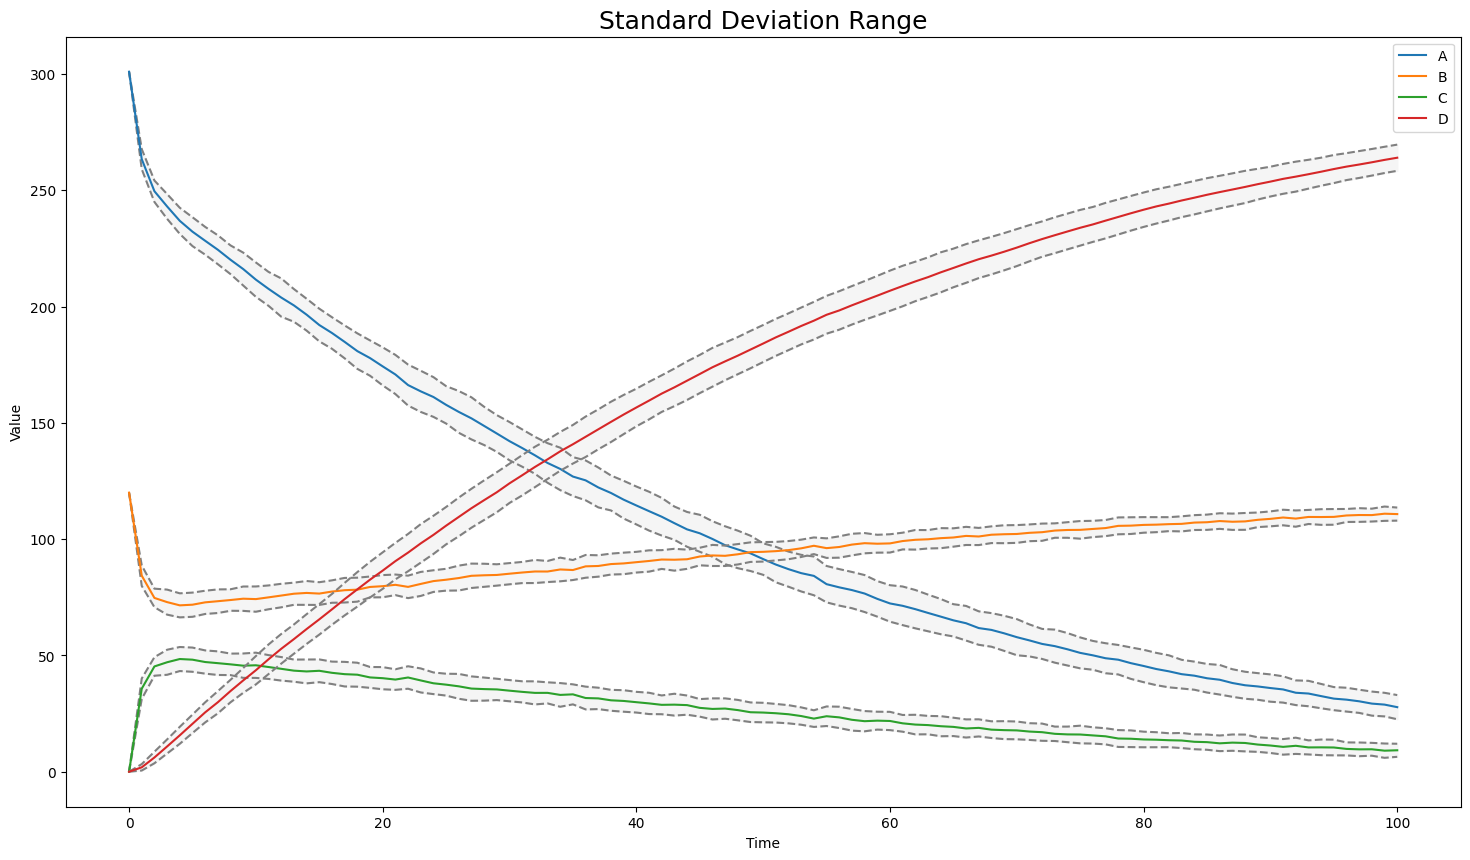

In [10]:
ensemble.plot_std_dev_range()